# Keras implementation of GDAM
## Gradient Descent with Altruistic Momentum

This notebook requires aribenjamin's forked Keras.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano
from theano import tensor as T
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm


from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


%matplotlib inline

Using Theano backend.


## Load test datasets

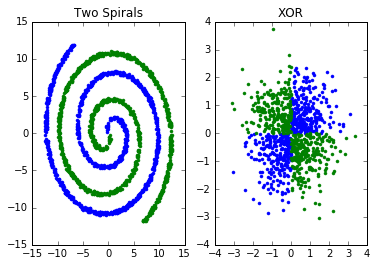

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
     Stolen from http://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    
    X = np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y))))
    Y = np.hstack((np.zeros(n_points),np.ones(n_points)))
    
        # Convert into one-hot vectors
    num_labels = len(np.unique(Y))
    Y = np.eye(num_labels)[Y.astype(int)]
    
    return X, Y

def xor(n_points):
    X = np.random.randn(n_points, 2)
    Y = np.logical_xor(X[:,0]>0,X[:,1]>0)
    
    # Convert into one-hot vectors
    num_labels = len(np.unique(Y))
    Y = np.eye(num_labels)[Y.astype(int)]
    return X,Y


def get_iris_data():
    """ Read the iris data set and split them into training and test sets """
    iris   = datasets.load_iris()
    data   = iris.data
    target = iris.target

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors
    num_labels = len(np.unique(target))
    all_Y = np.eye(num_labels)[target]  # One liner trick!
    return all_X, all_Y


def load_mnist():
    # the data, shuffled and split between train and test sets
    # Stolen from https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

plt.subplot(121)
plt.title('Two Spirals')
X, y = twospirals(1000)
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')

plt.subplot(122)
plt.title('XOR')
X, y = xor(1000)
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')


plt.show()

In [7]:
def run_MNIST(opt):
    batch_size = 128
    epochs = 1

    x_train, y_train, x_test, y_test = load_mnist()

    model = Sequential()
    model.add(Dense(850, activation='relu', input_shape=(784,)))
    model.add(Dense(90, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    #model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [8]:
opt = RMSprop()
run_MNIST(opt)

60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 8s - loss: 0.2557 - acc: 0.9208 - val_loss: 0.1250 - val_acc: 0.9607
Test loss: 0.124990585847
Test accuracy: 0.9607


In [9]:
opt = keras.optimizers.SGD(lr=0.7)
run_MNIST(opt)

60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 4s - loss: 0.5385 - acc: 0.8286 - val_loss: 0.1254 - val_acc: 0.9613
Test loss: 0.12536533432
Test accuracy: 0.9613


In [22]:
from keras.optimizers import *

class my_GDAM(Optimizer):
    """Gradient descent with altruistic momentum


    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        altruicity: float >= 0.

    """

    def __init__(self, lr=0.01, decay=0.,
                 altruicity = 0, altruicity_decay = 0, **kwargs):
        super(my_GDAM, self).__init__(**kwargs)
        self.iterations = K.variable(0., name='iterations')
        self.lr = K.variable(lr, name='lr')
        self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.altruicity = K.variable(altruicity, name='altruicity')
        self.altruicity_decay = K.variable(altruicity, name='altruicity_decay')
        self.init_altruicity_decay = altruicity_decay

    def get_updates(self, params, constraints, loss):
        # Here we redefine the cost function such that it includes the product
        # of the previous update and the update to be made

            #This is called in _make_train_function, within
            # the Model class's fit function. The train function is then
            # fed to _fit_loop, where it is called every batch.
            # => thus only called once. The list of update rules is what matters.


        # to store things between updates,
        # initialize them then put them in the update list
        shapes = [K.get_variable_shape(p) for p in params]
        old_grads = [K.zeros(shape) for shape in shapes]

        # get gradients
        grads = self.get_gradients(loss, params)

        self.updates = []

        # smart way to implement a decay w/o exponentiation
        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))
            self.updates .append(K.update_add(self.iterations, 1))

        altruicity = self.altruicity
        if self.init_altruicity_decay > 0:
            altruicity *= (1. / (1. + self.altruicity_decay * self.iterations))

        # sum product of proposed and past updates
        sum_grads = 0
        for g, o in zip(grads, old_grads):
            # not sure if .sum is the fastest way to reduce here
            sum_grads += (g*o).sum()

        ## Currently the altruicity term multiplied by the third power of lr.
        ## Consider removing lr**2 here
        full_loss = loss - altruicity * sum_grads * lr*lr

        # get final gradients.
            ## TO DO: we're recalculating the computational tree of 'grads' Here
            ## does this matter? Is it cached anyway? Think so.
        full_grads = self.get_gradients(full_loss, params)


        for p, fg, g, og in zip(params, full_grads, grads, old_grads):
            # update old_grads
            self.updates.append(K.update(og, g))

            # SG
            new_p = p - fg * lr

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'altruicity': float(K.get_value(self.altruicity)),
                  'decay': float(K.get_value(self.decay)),
                  'altruicity_decay': self.altruicity_decay}
        base_config = super(GDAM, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [23]:
opt = my_GDAM(lr=0.1,altruicity=.1,altruicity_decay=0.1)
run_MNIST(opt)

60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 7s - loss: 0.3955 - acc: 0.8857 - val_loss: 0.1818 - val_acc: 0.9444
Test loss: 0.181795050576
Test accuracy: 0.9444
